<a href="https://colab.research.google.com/github/Eman-diab-hussein/deep/blob/main/ML_Lab_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.utils import plot_model
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error

In [ ]:
# read the dataset
Data=pd.read_csv("AAPL.csv")
Data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


Only the 2020 to 2021 data will be used for training, the data before this time is found to be useless in making the prediction 2021 afterwards

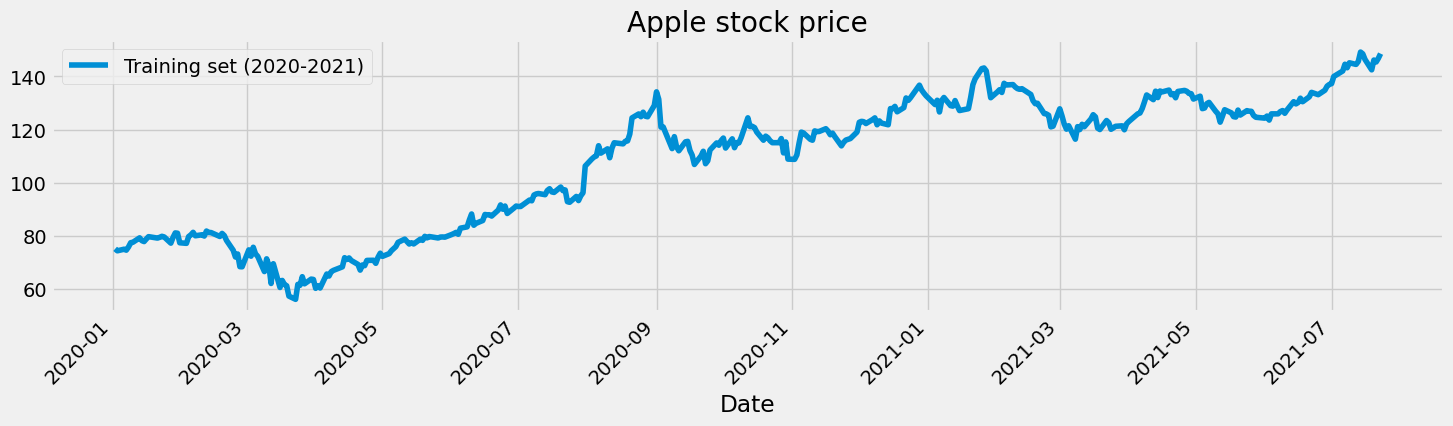

In [ ]:

# Convert the 'Date' column to datetime
Data['Date'] = pd.to_datetime(Data['Date'], format='%Y-%m-%d')

# Set the 'Date' column as the index
Data.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(10, 5))
Data['Close']['2020':'2021-07-25'].plot(figsize=(16, 4), legend=True)
plt.xticks(rotation=45)
plt.legend(['Training set (2020-2021)'])
plt.title('Apple stock price')
plt.show()


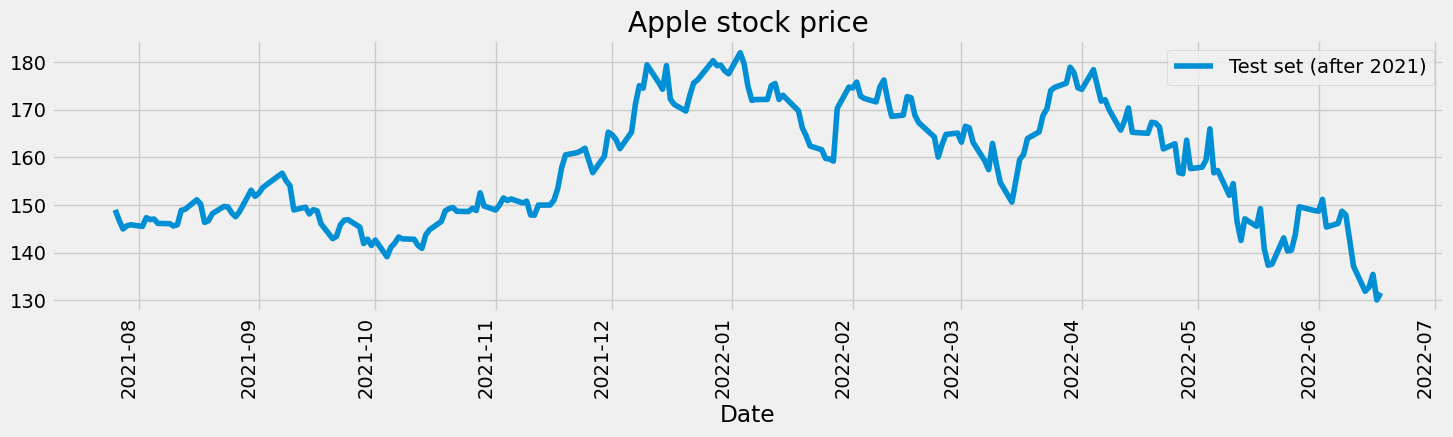

In [ ]:
Data['Close']['2021-07-25':].plot(figsize=(16,4),legend=True)
plt.xticks(rotation=90)
plt.legend(['Test set (after 2021)'])
plt.title('Apple stock price')
plt.show()

In [ ]:
#Extract High column data
Train_set=Data['Close']['2020-03-10':'2021-07-25'].values
Test_set=Data['Close']['2021-07-25':].values
S=MinMaxScaler()
scaled_train=S.fit_transform(Train_set.reshape(-1,1))
scaled_test=S.transform(Test_set.reshape(-1,1))

Because RNNs work on sequence, inorder to predict on the test set, the model must see the data from the train set, last 20 data from train set will be used to predict the first data point of the test set

In [ ]:
Test_set_to_prediction=np.concatenate([scaled_train[-21:],scaled_test],axis=0)


In [ ]:
print (Train_set)

[ 71.334999  68.857498  62.057499  69.4925    60.552502  63.215
  61.6675    61.195     57.310001  56.092499  61.720001  61.380001
  64.610001  61.935001  63.702499  63.572498  60.227501  61.232498
  60.352501  65.6175    64.857498  66.517502  66.997498  68.3125
  71.762497  71.107498  71.672501  70.699997  69.232498  67.092499
  69.025002  68.7575    70.7425    70.792503  69.644997  71.932503
  73.449997  72.267502  73.290001  74.389999  75.157501  75.934998
  77.532501  78.752502  77.852501  76.912498  77.385002  76.927498
  78.739998  78.285004  79.807503  79.212502  79.722504  79.182503
  79.527496  79.5625    79.485001  80.462502  80.834999  81.279999
  80.580002  82.875     83.364998  85.997498  88.209999  83.974998
  84.699997  85.747498  88.019997  87.897499  87.932503  87.43
  89.717499  91.6325    90.014999  91.209999  88.407501  90.445
  91.199997  91.027496  91.027496  93.462502  93.172501  95.342499
  95.752502  95.919998  95.477501  97.057503  97.724998  96.522499
  96.32

Generate the sequence data




In [ ]:
window_size = 3
def windowed_dataset(series,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series.reshape(-1,1))

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Create batches of windows
    dataset = dataset.batch(len(series)).prefetch(1)
    return dataset

In [ ]:
X,y=np.array(list(windowed_dataset(scaled_train,10))[0][0]),np.array(list(windowed_dataset(scaled_train,10))[0][1])

In [ ]:
print (X)
print(y)

[[[0.16379659]
  [0.13717325]
  [0.06410016]]

 [[0.13717325]
  [0.06410016]
  [0.14399701]]

 [[0.06410016]
  [0.14399701]
  [0.04792739]]

 ...

 [[0.97034097]
  [0.92800153]
  [0.96776187]]

 [[0.92800153]
  [0.96776187]
  [0.95970233]]

 [[0.96776187]
  [0.95970233]
  [0.97474689]]]
[[0.14399701]
 [0.04792739]
 [0.07653871]
 [0.05990921]
 [0.0548317 ]
 [0.01308333]
 [0.        ]
 [0.06047339]
 [0.05681973]
 [0.09152946]
 [0.06278379]
 [0.0817774 ]
 [0.0803804 ]
 [0.04443492]
 [0.05523466]
 [0.04577817]
 [0.10235609]
 [0.09418907]
 [0.11202755]
 [0.11718561]
 [0.13131668]
 [0.1683905 ]
 [0.16135185]
 [0.1674234 ]
 [0.15697283]
 [0.14120302]
 [0.11820649]
 [0.13897326]
 [0.13609867]
 [0.15742957]
 [0.1579669 ]
 [0.14563575]
 [0.17021739]
 [0.18652445]
 [0.17381731]
 [0.18480513]
 [0.19662575]
 [0.20487336]
 [0.21322838]
 [0.23039522]
 [0.2435054 ]
 [0.23383395]
 [0.22373264]
 [0.22881019]
 [0.22389383]
 [0.24337104]
 [0.23848165]
 [0.25484249]
 [0.24844859]
 [0.25392909]
 [0.24812621

In [ ]:
X_test,y_test=np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][0]),np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][1])

In [ ]:
Model1=Sequential(
[
    LSTM(units=60,input_shape=(X.shape[1],1),return_sequences=True),
    LSTM(units=50,return_sequences=True),
    LSTM(units=30,return_sequences=True),
    LSTM(units=20,return_sequences=True),
    LSTM(10),
    Dense(units=1),
])

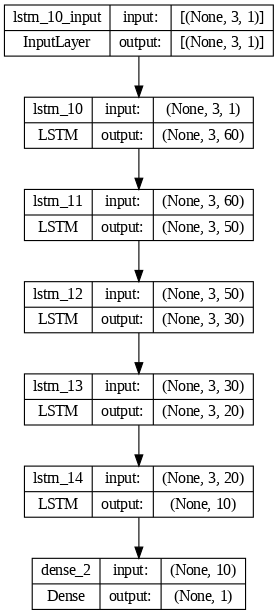

In [ ]:
plot_model(Model1, show_shapes = True,expand_nested = True,dpi = 80)


In [ ]:
Model1.compile(optimizer = "adam",loss='mean_squared_error')


In [ ]:
Model1.summary()


In [ ]:
callbacks=tf.keras.callbacks.ModelCheckpoint(
    'Model.keras',
    monitor= 'loss',
    save_best_only=True)
history= Model1.fit(X,y,epochs=50,callbacks=[callbacks])

Epoch 1/50
11/11 [==============================] - 12s 18ms/step - loss: 0.3916
Epoch 2/50
11/11 [==============================] - 0s 18ms/step - loss: 0.2821
Epoch 3/50
11/11 [==============================] - 0s 18ms/step - loss: 0.1026
Epoch 4/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0504
Epoch 5/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0336
Epoch 6/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0275
Epoch 7/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0217
Epoch 8/50
11/11 [==============================] - 0s 48ms/step - loss: 0.0156
Epoch 9/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0099
Epoch 10/50
11/11 [==============================] - 1s 69ms/step - loss: 0.0059
Epoch 11/50
11/11 [==============================] - 1s 112ms/step - loss: 0.0035
Epoch 12/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0028
Epoch 13/50
11/11 [================

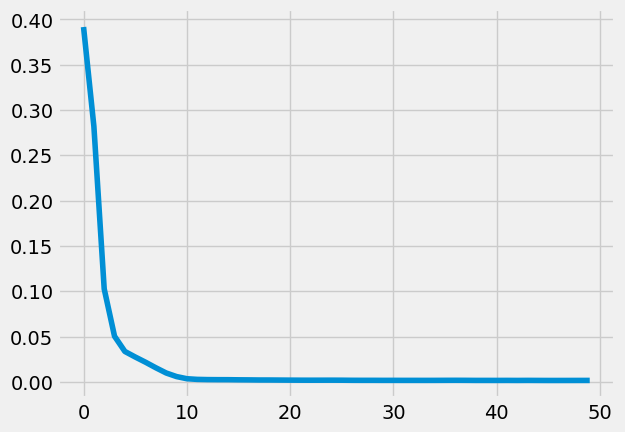

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
Output1=Model1.predict(X_test)

8/8 [==============================] - 2s 4ms/step


In [ ]:
Model1.evaluate(y_test,Output1)

8/8 [==============================] - 2s 3ms/step - loss: 0.8240


0.8240024447441101

In [ ]:
mean_squared_error(y_test,Output1)

0.011999508618631999

In [ ]:
mean_squared_error(S.inverse_transform(y_test),S.inverse_transform(Output1))

103.91213745788012

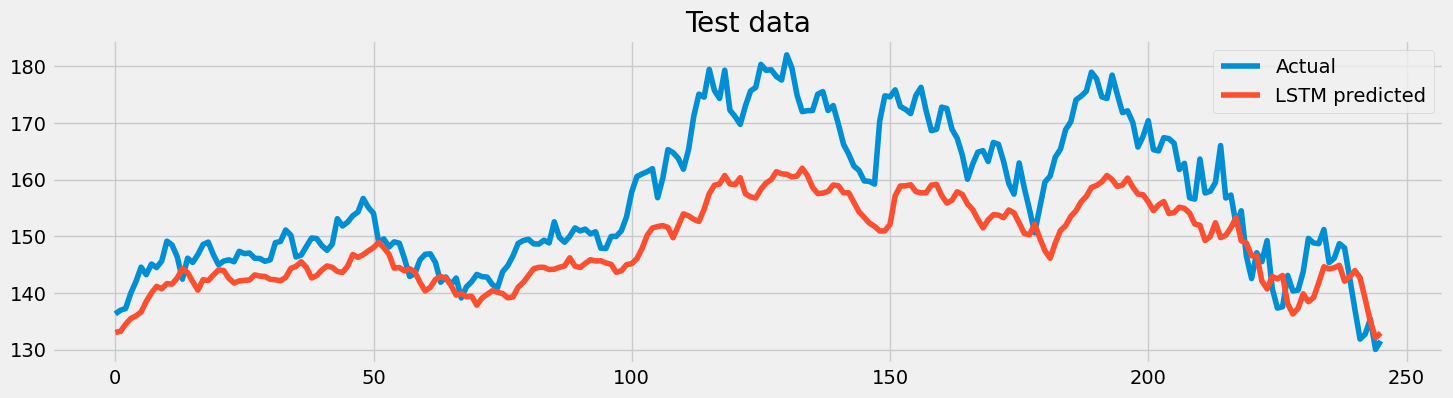

In [ ]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(Output1),label="LSTM predicted")
plt.legend()
plt.show()

In [ ]:
Out=Model1.predict(X)

11/11 [==============================] - 0s 4ms/step


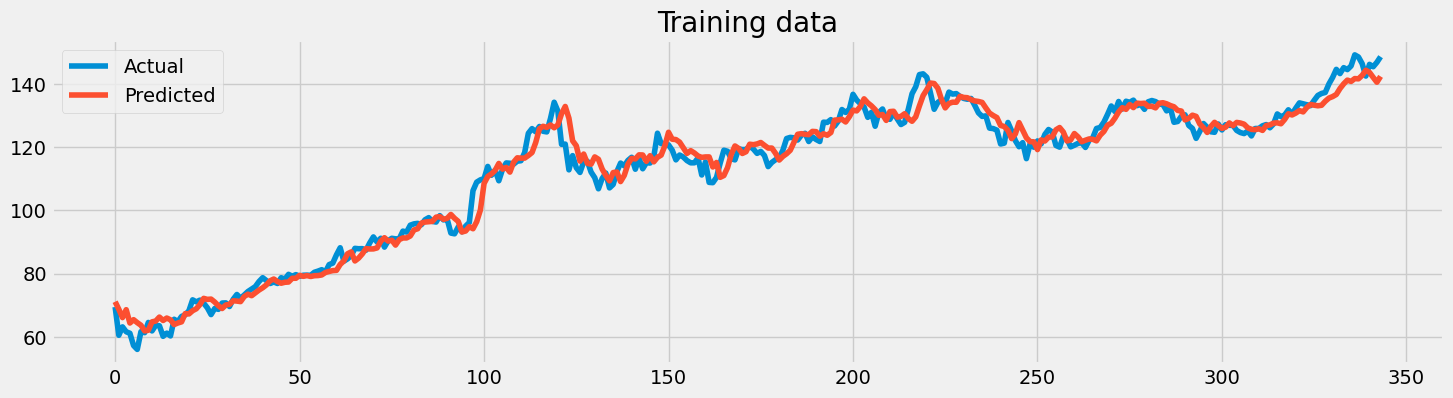

In [ ]:
q=np.arange(0,len(y))
plt.figure(figsize=(16,4))
plt.title("Training data",fontsize=20)
plt.plot(q,S.inverse_transform(y),label='Actual')
plt.plot(q,S.inverse_transform(Out),label='Predicted')
plt.legend()
plt.show()

Simple Dense Layer


In [ ]:
Model2=Sequential(
[
    Dense(units=30,input_shape=(X.shape[1],1),activation='relu'),
    Dense(units=20,activation='relu'),
    Dense(units=10),
    Dense(units=1)
])

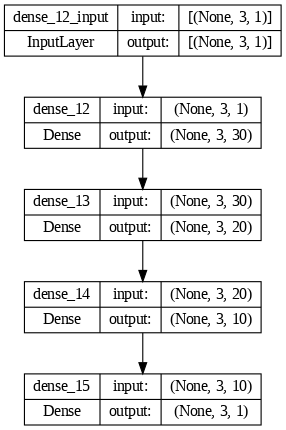

In [ ]:
plot_model(Model2, show_shapes = True,expand_nested = True,dpi = 80)


In [ ]:
Model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 3, 30)             60        
                                                                 
 dense_9 (Dense)             (None, 3, 20)             620       
                                                                 
 dense_10 (Dense)            (None, 3, 10)             210       
                                                                 
 dense_11 (Dense)            (None, 3, 1)              11        
                                                                 
Total params: 901 (3.52 KB)
Trainable params: 901 (3.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
Model2.compile(optimizer='adam',loss='mse')


In [ ]:
history2=Model2.fit(X,y,epochs=100,callbacks=[callbacks])

Epoch 1/100
11/11 [==============================] - 1s 3ms/step - loss: 0.4159
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1776
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0534
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 9/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 10/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 11/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 12/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 13/100
11/11 [=================

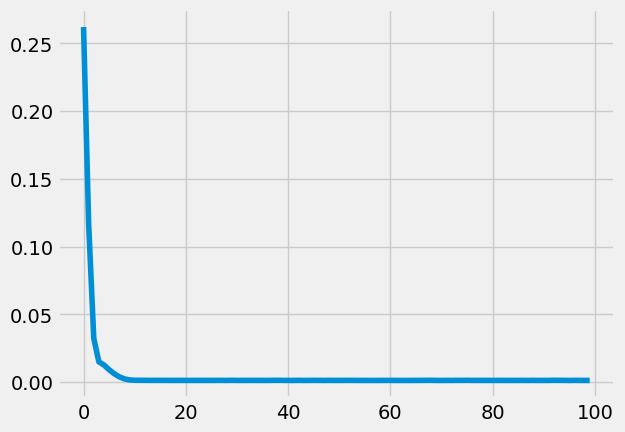

In [ ]:
plt.plot(history2.history['loss'])

In [ ]:
Output2=Model2.predict(X_test)

In [ ]:
Model2.evaluate(y_test,Output2)

8/8 [==============================] - 0s 2ms/step - loss: 0.0010


0.0010482127545401454

In [ ]:
mean_squared_error(S.inverse_transform(y_test),S.inverse_transform(a.reshape(-1,1)))

57.099984253125534

In [ ]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(a.reshape(-1,1)),label="Dense predicted")
plt.legend()
plt.show()